# Description
The objective of this analysis is to understand the benefits of the use of survival analysis for the modelling of credit risk lifetime default curves.
<br> The standard approach used in the industry is to:
1. Train a classification model in a single target, usually default in 12 months
2. Segment the portfolio in homogeneous risk groups.
3. Calibrate the PD in 12 months over each group.
4. calibrate the lifetime pd curve over each group.

<br> The approach described above breaks down each modelling component in different challenges, the scorecard is only worried with discrimination of the population between clients with low and high risk of defaulting while the calibration of the risk curves deal with both level and shape of the risk curves. This allows for a modular approach, although it implements additional steps in the modelling.
<br> An alternative approach would be using survival analysis methods which allows the modelling of the full lifetime curve in one single model.

This analysis aims to explore the use of survival models to calibrate pd lifetime risk curves

This notebook will create a syntetic set of data upon which the analysis will be done

# TO DO
1. Include default rate plot inside class
2. Check if it is possible to do the default rate by groups inside class
3. check impact of changing variables
4. Include WO rate (LGD)
5. clean notebook
6. Adujust PD for survivors???

# Setup

In [10]:
import pandas as pd
import numpy as np
import plotly.express as px
import scipy
from IPython.display import Image
from utils import colorRampPaletteFromDfColumn
import copy
from parallel_pandas import ParallelPandas
import datetime

In [11]:
ParallelPandas.initialize(n_cpu=14)
pd.set_option('display.max_rows', 1000)
output_path = "data/"

# Data Creation

In [12]:
def fit_power(x, shape, scale):
  return (scale * x ** (-shape))

def fit_exp(x, shape, scale):
  result = scale * np.exp(np.multiply(-shape, x))
  return result

def fit_weibull(x, shape, scale, d):
  result = (shape/scale)*np.power(((x+d)/scale), (shape-1)) * np.exp(-1 * np.power(((x+d)/scale), shape))
  return result

def fit_gamma(x, shape, scale, d=0):
  from scipy.special import gamma
  result = ((1 / (gamma(shape) * (scale ** shape))) * ((x+d) ** (shape - 1)) * np.exp(np.multiply(-1, (x+d)) / scale))
  return result

def logNormFunc(x, a, b, d):
  result = (1 / ((x+d) * b * np.power(2* np.pi, 1/2))) * np.exp(-1*(np.power(np.log(x+d) - a, 2) / (2*np.power(b, 2))))
  return result

def gamma_pdf(x, a, b):
  from scipy.special import gamma
  return (np.power(x, (a - 1)) * np.exp(np.divide(np.multiply(-1, x), b))) / (np.power(b, a) * gamma(a))

def exp_decay(x, a, b):
  return a * np.exp(np.multiply(-b, x))

def beta_pdf(x, a, b):
  from scipy.special import beta
  return np.divide((np.divide(x, np.power(60, (a - 1))) * np.power((1 - np.divide(x, 60)), (b - 1))), beta(a, b))

In [ ]:
class generate_sample:
    def __init__(self,
                 func,
                 func_parameters: dict,
                 risk_scores: dict,
                 risk_scores_dist: dict,
                 risk_scores_limits_dist: dict,
                 roll_rates: dict,
                 lifetime_target: int,
                 start_date: str = "2025-01-31",
                 n_months: int = 24,
                 n_sample: int = 10000,
                 wo_target: int = 360,
                 ccf: float = 0.5,
                 growth_func = logNormFunc,
                 growth_params = {
                                    'a' : 2.7,
                                    'b' : 1.0,
                                    'd' : 0
                                }
                 ):
        self.func = func
        self.func_parameters = func_parameters
        self.risk_scores = risk_scores
        self.risk_scores_dist = risk_scores_dist
        self.roll_rates = roll_rates
        self.lifetime_target = lifetime_target
        self.start_date = start_date
        self.n_months = n_months
        self.n_sample = n_sample
        self.risk_scores_limits_dist = risk_scores_limits_dist
        self.wo_target = wo_target
        self.ccf = ccf
        self.risk_curves = None
        self.growth_func = growth_func
        self.growth_params = growth_params
    
    def generate_pd_curve(self,
                          func, 
                          parameters: dict,
                          n_default_months: int,
                          cumulative_pd: float,
                          roll_rates: dict):
        """
        Generates a probability distribution curve for default lifetime risk.
        
        Parameters:
            func (callable): Function to calculate PD for given risk-band
            parameters (dict): Dictionary of parameters specific for the function.
            n_default_months (int): Number of months to simulate default progression
            cumulative_pd (float): Cumulative probability of default for the entire curve
            roll_rates (dict): Roll rates between credit states
            
        Returns:
            pd.DataFrame: DataFrame containing PD curves with additional columns
        """
        
        df = pd.DataFrame(range(0, n_default_months+1), columns=["default_month"])
        df['p'] = func(df['default_month'], **parameters) 
        df['p'] = df['p'].fillna(0)
        df['p'] = (df['p'] / df['p'].sum()) * cumulative_pd
        df['cum_p'] = df['p'].cumsum() 
        
        multiplication_roll_rates = 1
        for days_late_i, roll_rate_i in roll_rates.items():
            if days_late_i <= 90:
                multiplication_roll_rates = multiplication_roll_rates * roll_rate_i
                
        df['pd_lifetime'] = (df['p'].sum() - df['cum_p']) * multiplication_roll_rates
        
        # Calculate forward-looking 12-month sum using rolling
        df['pd_12m'] = (df[::-1]['p'].rolling(window=12, min_periods=1, closed='left').sum().iloc[::-1]) * multiplication_roll_rates
        
        return df

    def generate_pd_curve_by_risk_score(self):
        result_dfs = list()
        for risk_band_i, lifetime_pd_i in self.risk_scores.items():
            func_parameters = copy.deepcopy(self.func_parameters)
            func_parameters['a'] = (self.func_parameters['a'] + risk_band_i / 2)
            df_temp = self.generate_pd_curve(self.func, 
                                        func_parameters, 
                                        self.lifetime_target, 
                                        lifetime_pd_i, 
                                        self.roll_rates)
            df_temp['risk_band'] = risk_band_i
            result_dfs.append(df_temp)
        result = pd.concat(result_dfs)
        self.risk_curves = result
        return self.risk_curves
        
    def generate_origination_sample(self,
                                    start_date: str,
                                    n_months: int, 
                                    n_sample: int,
                                    risk_scores_dist: dict,):
        growth_months = np.arange(0, n_months)
        growth_curve = self.growth_func(growth_months+1, **self.growth_params)
        growth_curve = growth_curve / growth_curve.sum()

        id_list = range(1, n_sample+1)
        df_sample = pd.DataFrame(id_list, columns=['id'])
        df_sample['create_date_aux'] = np.random.choice(growth_months, p=growth_curve, size=n_sample)
        df_sample['created_date'] = pd.to_datetime(pd.to_datetime(start_date) + df_sample['create_date_aux'].p_apply(lambda x : pd.offsets.MonthEnd(x)))
        df_sample['risk_band'] = np.random.choice(list(risk_scores_dist.keys()), size=n_sample, p=list(risk_scores_dist.values()))
        df_sample = df_sample.drop("create_date_aux", axis="columns")
        return df_sample
    
    def withMaxCreditLimit(self, df: pd.DataFrame, risk_scores_limits_dist: dict):
        result = df.copy()
        result['min_limit_pol'] = result['risk_band'].p_apply(lambda x : risk_scores_limits_dist[x][0])
        result['max_limit_pol'] = result['risk_band'].p_apply(lambda x : risk_scores_limits_dist[x][1])
        result['credit_card_max_limit'] = 100 * np.random.randint(result['min_limit_pol']/100,
                                                                  result['max_limit_pol']/100) 
                                                    
        return result
    
    def withRiskCurves(self, df: pd.DataFrame, risk_curves: pd.DataFrame):
        result= df.merge(risk_curves, on=['risk_band'], how='left')
        result['date'] = pd.to_datetime(result['created_date'] + result['default_month'].p_apply(lambda x: pd.offsets.MonthEnd(int(x))))
        result = result.rename({'default_month':'tenure'}, axis='columns')
        return result

    def withDefaultsFromRiskCurves(self, df: pd.DataFrame, roll_rates: dict):
        result = df.copy()
        result = result.sort_values(['id', 'date'])
        result['is_late'] = np.random.binomial(1, p=result['p'])
        result['late_start_date'] = pd.to_datetime(np.where(result['is_late'] == 1, result['date'], None))
        result['late_start_date'] = result.groupby('id')['late_start_date'].transform('min')
        result['days_late'] = np.where(result['late_start_date'] == result['date'], 1, None)
        for days_late_i, roll_rate_i in roll_rates.items():
            result['days_late_last_month'] = result.groupby('id')['days_late'].transform('shift', 1)
            result['prob_rr'] = roll_rate_i
            result['rgn'] = np.random.binomial(1, p=result['prob_rr'], size=result.shape[0])
            result['days_late'] = np.where(result['days_late_last_month']==np.max([1, days_late_i-30]), 
                                        result['rgn'] *days_late_i, 
                                        result['days_late'])
            if days_late_i != list(roll_rates.keys())[-1]:
                result = result.drop(['days_late_last_month', 'rgn', 'prob_rr'], axis='columns')
        result['days_late'] = result.groupby('id')['days_late'].transform('ffill')
        result['days_late'] = result['days_late'].fillna(0)
        result['is_default'] = np.where(result['days_late'] == 90, 1, 0)
        result['n_late_status'] = result.groupby('id')['is_late'].transform('sum')
        return result
    
    def withBalance(self, df: pd.DataFrame):
        def _expit(x):
            return 1 / (1+np.exp(-1 * x))

        def min_max_normalization(X, min_: float = None, max_: float = None):
            if min_ is None:
                min_ = X.min(axis=0)
            if max_ is None:
                max_ = X.max(axis=0)
            X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
            X_scaled = X_std * (max_ - min_) + min_
            return X_scaled
        
        result = df.copy()
        
        result['utilisation'] = np.where(result['default_flag']==1, 
                                         np.random.normal(0.01, 0.5, size=result.shape[0]),
                                         np.random.normal(0.00, 0.5, size=result.shape[0]))
        result['utilisation'] = result.groupby('id')['utilisation'].transform('cumsum')
        result['utilisation'] = result.groupby('id')['utilisation'].transform(min_max_normalization, -4, 5)
        result['utilisation'] = _expit(result['utilisation'])
        result['balance'] = result['utilisation'] * result['credit_card_max_limit']
        
        #default always with 100% utilisation
        result['balance'] = np.where(result['days_late']==30, result['credit_card_max_limit'], result['balance'])
        
        ## block at 30 and don't allow defaulted cards to return to spend
        result['balance'] = np.where((result['date'] > result['default_date_ever']) | (result['days_late']>30), np.nan, result['balance'])
        result['balance'] = result.groupby('id')['balance'].transform('ffill')

        result['utilisation'] = result['balance'] / result['credit_card_max_limit']
        return result


    def withDefaultFlag(self, df: pd.DataFrame):
        result = df.copy()
        result['default_date_aux'] = pd.to_datetime(np.where(result['is_default']==1, result['date'], None))
        result = result.sort_values(['id', 'date'])
        result['default_date'] = result.groupby('id')['default_date_aux'].transform('bfill')
        result['default_date_ever'] = result.groupby('id')['default_date_aux'].transform('min')

        result = result.drop('default_date_aux', axis='columns')
        result['default_month'] = pd.to_numeric(np.where(result['default_date'].isnull(), None,
                                        (result['default_date'].dt.to_period('M').astype(int) 
                                            - result['date'].dt.to_period('M').astype(int))))
        result['default_flag'] = np.where(result['default_month'].isnull(),0,1)
        return result
    
    def withDefaultBalance(self, df: pd.DataFrame):
        result = df.copy()
        result['default_balance'] = np.where(result['date'] == result['default_date'], result['balance'], np.nan)
        result['default_balance'] = result.groupby('id')['default_balance'].transform('bfill')
        
        result['default_limit'] = np.where(result['date'] == result['default_date'], result['credit_card_max_limit'], np.nan)
        result['default_limit'] = result.groupby('id')['default_limit'].transform('bfill')
        return result
    
    def withBalanceAtWo(self, df: pd.DataFrame):
        result = df.copy()
        result['wo_date'] = pd.to_datetime(np.where(result['days_late'] == self.wo_target, result['date'], None))
        result = result.sort_values(['id', 'date'])
        result['wo_date'] = result.groupby('id')['wo_date'].transform('bfill')
        result['wo_month'] = pd.to_numeric(np.where(result['wo_date'].isnull(), None,
                                        (result['wo_date'].dt.to_period('M').astype(int) 
                                            - result['date'].dt.to_period('M').astype(int))))
        result['wo_flag'] = np.where(result['wo_month'].isnull(),0,1)
        result['wo_balance'] = np.where(result['date'] == result['wo_date'], result['balance'], np.nan)
        result['wo_balance'] = result.groupby('id')['wo_balance'].transform('bfill')
        return result
    
    def withLossMovement(self, df: pd.DataFrame):
        df['loss_balance'] = np.where(df['days_late'] >= self.wo_target, df['balance'], 0)
        
        df['recovered_balance'] = np.where((df['date'] > df['default_date_ever']) & (df['days_late']==0), df['balance'], 0)

        df['balance'] = np.where(df['days_late'] >= self.wo_target, 0, df['balance'])
        df['balance'] = np.where((df['date'] > df['default_date_ever']) & (df['days_late']==0), 0, df['balance'])
        
        df['credit_card_max_limit'] = np.where(df['days_late'] >= self.wo_target, 0, df['credit_card_max_limit'])
        return df
    
    def withStages(self, df: pd.DataFrame):
        df['stage'] = np.where(df['days_late'] >= 90, 3,
                               np.where(df['days_late'] >= 30, 2, 1))
        return df
    
    def withPD(self, df: pd.DataFrame):
        # adjust for delinquency
        rr_df = pd.DataFrame(self.roll_rates.values(), index=self.roll_rates.keys(), columns=['roll_rates']).reset_index(names='days_late')
        rr_df = rr_df[rr_df['days_late'] <= 90]
        rr_df['days_late'] = np.clip(rr_df['days_late'] - 30, 1, 60)
        rr_df['cum_rr'] = rr_df['roll_rates'][::-1].cumprod()[::-1]

        pd_delinquent_dict = rr_df.set_index('days_late')[['cum_rr']].to_dict()['cum_rr']

        df['pd_12m'] = np.where(df['days_late'].between(1,90), df['days_late'].p_apply(lambda x: pd_delinquent_dict[np.clip(x, a_max=60, a_min=1)]), df['pd_12m'])
        df['pd_lifetime'] = np.where(df['days_late'].between(1,90), df['days_late'].p_apply(lambda x: pd_delinquent_dict[np.clip(x, a_max=60, a_min=1)]), df['pd_lifetime'])

        # adjust for stage
        df['pd_12m'] = np.where(df['stage']==3, 1, df['pd_12m'])
        df['pd_lifetime'] = np.where(df['stage']==3, 1, df['pd_lifetime'])
        return df
    
    def withLGD(self, df: pd.DataFrame, roll_rates: dict, wo_target: int):
        rr_df = pd.DataFrame(roll_rates.values(), index=roll_rates.keys(), columns=['roll_rates']).reset_index(names='days_late')
        rr_df['cum_rr'] = np.where(rr_df['days_late'].between(91, wo_target), rr_df['roll_rates'][::-1].cumprod()[::-1], np.nan)
        rr_df['cum_rr'] = rr_df['cum_rr'].bfill()
        lgd_dict = rr_df.set_index('days_late')[['cum_rr']].to_dict()['cum_rr']

        days_late_list = rr_df[rr_df['days_late'] > 90]['days_late']

        result = df.copy()
        result['lgd'] = result['days_late'].p_apply(lambda x: lgd_dict[np.clip(x+30, a_max=days_late_list.max(), a_min=days_late_list.min())]).fillna(1.0)
        return result
    
    def withEAD(self, df: pd.DataFrame, ccf: float):
        result = df.copy()
        result['ead'] = result['balance'] + ccf * (result['credit_card_max_limit'] - result['balance'])
        result['ead'] = np.where(result['stage'] == 3, result['balance'], result['ead'])
        result['ead'] = np.where(result['date'] > result['default_date_ever'], result['balance'], result['ead'])
        return result
    
    def withECL(self, df: pd.DataFrame):
        result = df.copy()
        result['edb_12m'] = result['pd_12m'] * result['ead']
        result['edb_lifetime'] = result['pd_lifetime'] * result['ead']
        result['ecl_12m'] = result['pd_12m'] * result['ead'] * result['lgd']
        result['ecl_lifetime'] = result['pd_lifetime'] * result['ead'] * result['lgd']
        result['ecl'] = np.where(result['stage']==1, result['ecl_12m'], result['ecl_lifetime'])
        result['pd'] = np.where(result['stage']==1, result['pd_12m'], result['pd_lifetime'])
        return result

    def filterFutureDates(self, df: pd.DataFrame):
        result = df[df['date'] <= df['created_date'].max(axis='rows')]
        return result

    def filterAlreadyDefaulted(self, df: pd.DataFrame):
        filter_df = (df['default_month']>0) | (df['default_month'].isnull())
        result = df[filter_df]
        return result

    def withCompleteDefaultMonths(self, df: pd.DataFrame, lifetime: int):
        default_months = pd.DataFrame(range(1,lifetime+1), columns=['complete_default_months'])
        id_df = df[['date', 'id']].drop_duplicates()\
                    .merge(default_months, how='cross')
        
        result = id_df.merge(df, on=['date', 'id'], how='outer')
        result['default_flag'] = np.where(result['default_month'] == result['complete_default_months'], 1, 0)
        result = result\
                    .drop('default_month', axis='columns')\
                    .rename({'complete_default_months':'default_month'}, axis='columns')
        result['cum_defaults'] = result.sort_values(['date', 'id']).groupby(['date', 'id'])['default_flag'].transform('cumsum')
        return result
    
    def plotFigAsImage(self, fig, plot_as_png: bool):
        if plot_as_png:
            return Image(fig.to_image('png'))
        else:
            return fig

    def plot_growth_curve(self, plot_as_png: bool = False):
        growth_months = np.arange(0, self.n_months)
        growth_curve = self.growth_func(growth_months+1, **self.growth_params)
        growth_curve = growth_curve / growth_curve.sum()
        cum_growth_curve = np.cumsum(growth_curve)

        data_chart = pd.DataFrame({
            'months' : growth_months,
            'growth_distribution' : growth_curve,
            'cum_growth_dist' : cum_growth_curve
        })

        data_chart = data_chart.melt(id_vars='months')

        fig = px.line(
            data_chart,
            x='months',
            y='value',
            color='variable',
            facet_col='variable',
            template='none',
            width=1000
        )
        fig.update_yaxes(matches=None, showticklabels=True,  rangemode='tozero')
        return self.plotFigAsImage(fig, plot_as_png)

    def plot_default_rates(self, plot_as_png: bool = False):
        data_chart = self.df_sample\
            .groupby(['date','default_month'])\
            .agg({
                'id' : 'count',
                'cum_defaults': 'mean',
                'default_flag': 'mean'
            }) \
            .reset_index()\
            .melt(id_vars=['date', 'default_month'])


        fig = px.line(
            data_chart,
            x='default_month',
            y='value',
            facet_col='variable',
            color='date',
            template='none',
            width=1000
        )

        fig.update_yaxes(matches=None, showticklabels=True)
        return self.plotFigAsImage(fig, plot_as_png)

    def plot_risk_curves(self, plot_as_png: bool = False):
        if self.risk_curves is None:
            self.generate_pd_curve_by_risk_score()
        data_chart = self.risk_curves.melt(id_vars=['default_month', 'risk_band'])
        fig = px.line(
            data_chart,
            x='default_month',
            y='value',
            facet_col='variable',
            color='risk_band',
            template = 'none',
            width=1000
        )
        fig.update_yaxes(matches=None, showticklabels=True)

        return self.plotFigAsImage(fig, plot_as_png)
        
    def plot_risk_curves2(self, plot_as_png: bool = False):
        if self.risk_curves is None:
            self.generate_pd_curve_by_risk_score()
        data_chart = self.risk_curves.melt(id_vars=['default_month', 'risk_band'])
        fig = px.line(
            data_chart,
            x='default_month',
            y='value',
            facet_col='risk_band',
            facet_col_wrap=4,
            color='variable',
            template = 'none',
            width=1000
        )
        fig.update_yaxes(matches=None, showticklabels=True)

        return self.plotFigAsImage(fig, plot_as_png)

    def withSelectedDF(self):
        return self.df_sample[self.selected_cols]
    
    def run(self):
        self.generate_pd_curve_by_risk_score()

        self.df_sample = self.generate_origination_sample(self.start_date, self.n_months, self.n_sample, self.risk_scores_dist)\
                            .pipe(self.withMaxCreditLimit, self.risk_scores_limits_dist)\
                            .pipe(self.withRiskCurves, self.risk_curves)\
                            .pipe(self.withDefaultsFromRiskCurves, self.roll_rates)\
                            .pipe(self.withDefaultFlag)\
                            .pipe(self.withBalance)\
                            .pipe(self.withDefaultBalance)\
                            .pipe(self.withBalanceAtWo)\
                            .pipe(self.withLossMovement)\
                            .pipe(self.withStages)\
                            .pipe(self.withPD)\
                            .pipe(self.withLGD, self.roll_rates, self.wo_target)\
                            .pipe(self.withEAD, self.ccf)\
                            .pipe(self.withECL)
                            
        
        return self.df_sample
    
    def sampleWithFutureDatesFiltered(self):
        result = self.df_sample\
                            .pipe(self.filterFutureDates)\
                            .pipe(self.withDefaultFlag)\
                            .pipe(self.withDefaultBalance)\
                            .pipe(self.withBalanceAtWo)\
                            .pipe(self.withLossMovement)\
                            .pipe(self.withStages)\
                            .pipe(self.withPD)\
                            .pipe(self.withLGD, self.roll_rates, self.wo_target)\
                            .pipe(self.withEAD, self.ccf)\
                            .pipe(self.withECL)
                            
        
        return result
    



In [58]:
func_parameters =  dict(
    a = 1.0,
    b = 0.6,
    d = 0
)

## risk_scored probablity of reaching 1 days late
risk_scores = {
    10 : 0.015,
     9 : 0.025,
     8 : 0.05,
     7 : 0.10,
     6 : 0.15,
     5 : 0.25,
     4 : 0.30,
     3 : 0.40,
     2 : 0.55,
     1 : 0.60
}

roll_rates = {
    30  :  0.50  , ## from 1-29    to 30-59
    60  :  0.75  , ## from 30-59   to 60-89
    90  :  0.80  , ## from 60-89   to 90-119
    120 :  0.90  , ## from 90-119  to 120-139
    150 :  0.95  , ## from 120-139 to 150-179
    180 :  0.999 , ## from 150-179 to 180-209
    210 :  0.999 , ## from 180-209 to 210-239
    240 :  0.999 , ## from 210-239 to 240-269
    270 :  0.999 , ## from 240-269 to 270-299
    300 :  0.999 , ## from 270-299 to 300-329
    330 :  0.999 , ## from 300-329 to 330-359
    360 :  0.9999, ## from 330-359 to 360-389
    390 :  1.0000, ## from 360-389 to 390-419
}


#parameters for sample size
lifetime_target = 100
start_date = "2025-01-31"
n_months = 12
n_sample = 30000

#distribution of originations
risk_scores_dist = {
    10 : 0.05 , 
     9 : 0.15 , 
     8 : 0.20 ,  
     7 : 0.15 ,
     6 : 0.15 ,
     5 : 0.10 ,
     4 : 0.07 ,
     3 : 0.055, 
     2 : 0.05 ,
     1 : 0.025,
}


risk_scores_limits_dist = {
    10 : [15000, 30000],
     9 : [10000, 15000],
     8 : [7000 , 10000],
     7 : [5000 , 7000 ],
     6 : [3000 , 5000 ],
     5 : [1000 , 3000 ],
     4 : [700  , 2000 ],
     3 : [700  , 1000 ],
     2 : [500  , 700  ],
     1 : [100  , 500  ],
}


growth_params = {
    'a' : 6,
    'b' : 1.5,
    'd' : 0
}

sample_generator = \
    generate_sample(func = logNormFunc,
                    func_parameters = func_parameters,
                    risk_scores = risk_scores,
                    risk_scores_dist = risk_scores_dist,
                    risk_scores_limits_dist = risk_scores_limits_dist,
                    roll_rates = roll_rates,
                    lifetime_target = lifetime_target,
                    start_date = start_date,
                    n_months = n_months,
                    n_sample = n_sample,
                    growth_params=growth_params,
                    ccf=1.0)

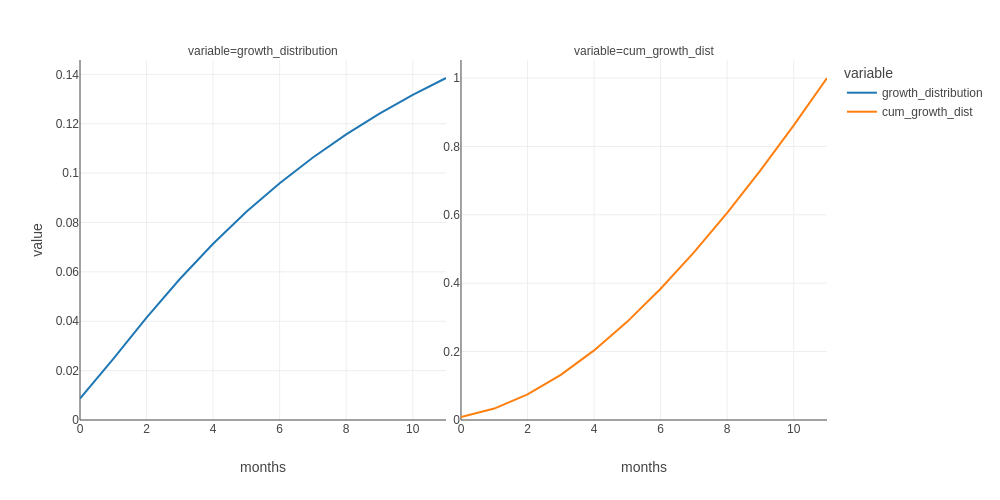

In [59]:
sample_generator.plot_growth_curve(plot_as_png=True)

/home/neon/Documents/Dev/Survival Analysis/Survival-Analysis/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log

/home/neon/Documents/Dev/Survival Analysis/Survival-Analysis/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log

/home/neon/Documents/Dev/Survival Analysis/Survival-Analysis/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log

/home/neon/Documents/Dev/Survival Analysis/Survival-Analysis/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log

/home/neon/Documents/Dev/Survival Analysis/Survival-Analysis/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log

/home/neon/Documents/Dev/Survival Analysis/Survival-Analysis/.venv/lib/python3.10/site-packages/pandas/core/ar

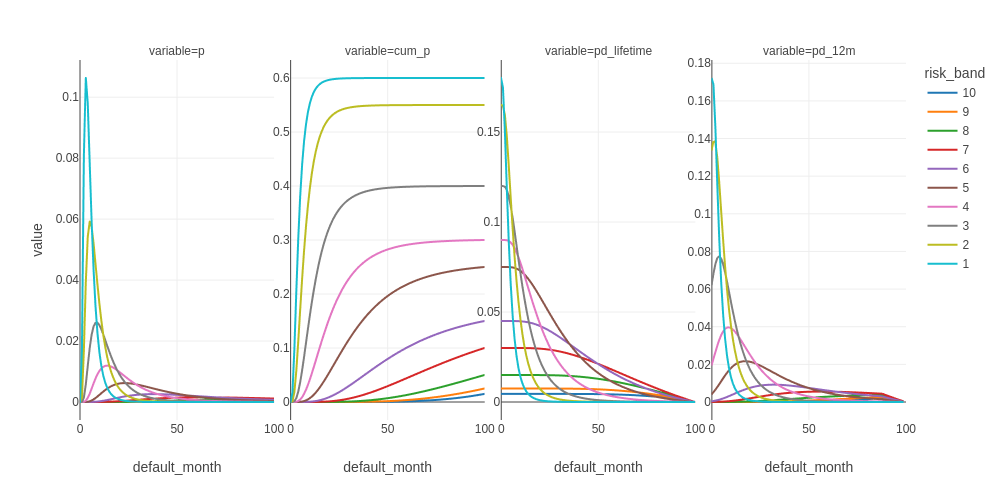

In [60]:
sample_generator.plot_risk_curves(plot_as_png=True)

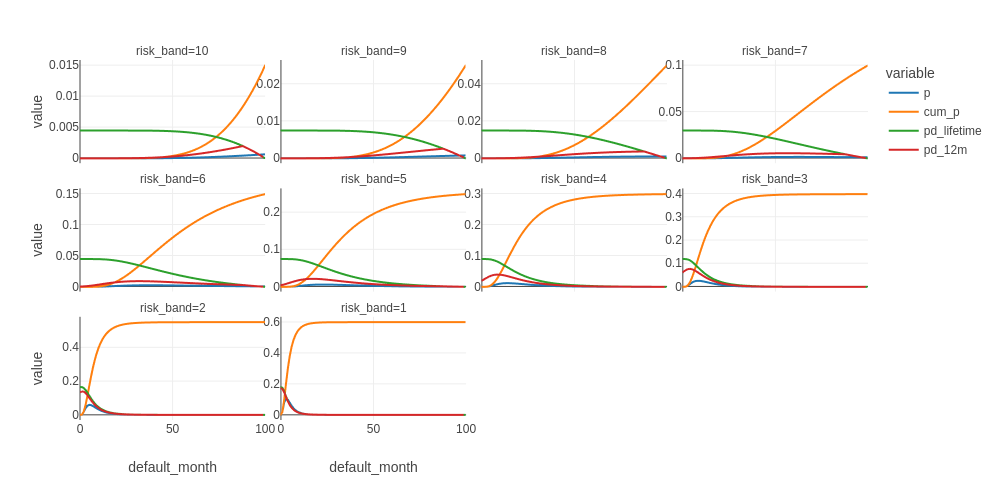

In [61]:
sample_generator.plot_risk_curves2(plot_as_png=True)

In [62]:
df_sample = sample_generator.run()
df_sample                

/home/neon/Documents/Dev/Survival Analysis/Survival-Analysis/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log

/home/neon/Documents/Dev/Survival Analysis/Survival-Analysis/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log

/home/neon/Documents/Dev/Survival Analysis/Survival-Analysis/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log

/home/neon/Documents/Dev/Survival Analysis/Survival-Analysis/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log

/home/neon/Documents/Dev/Survival Analysis/Survival-Analysis/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log

/home/neon/Documents/Dev/Survival Analysis/Survival-Analysis/.venv/lib/python3.10/site-packages/pandas/core/ar

,id,created_date,risk_band,min_limit_pol,max_limit_pol,credit_card_max_limit,tenure,p,cum_p,pd_lifetime,...,recovered_balance,stage,lgd,ead,edb_12m,edb_lifetime,ecl_12m,ecl_lifetime,ecl,pd
0,1,2025-09-30,6,3000,5000,3500,0,0.000000e+00,0.000000e+00,4.500000e-02,...,0.0,1,0.849798,3500.0,1.299625,1.575000e+02,1.104419,1.338432e+02,1.104419,0.000371
1,1,2025-09-30,6,3000,5000,3500,1,2.635080e-11,2.635080e-11,4.500000e-02,...,0.0,1,0.849798,3500.0,1.845186,1.575000e+02,1.568035,1.338432e+02,1.568035,0.000527
2,1,2025-09-30,6,3000,5000,3500,2,1.495335e-08,1.497970e-08,4.500000e-02,...,0.0,1,0.849798,3500.0,2.520696,1.575000e+02,2.142082,1.338431e+02,2.142082,0.000720
3,1,2025-09-30,6,3000,5000,3500,3,3.288547e-07,3.438344e-07,4.499990e-02,...,0.0,1,0.849798,3500.0,3.333332,1.574996e+02,2.832658,1.338428e+02,2.832658,0.000952
4,1,2025-09-30,6,3000,5000,3500,4,2.233971e-06,2.577806e-06,4.499923e-02,...,0.0,1,0.849798,3500.0,4.286259,1.574973e+02,3.642454,1.338409e+02,3.642454,0.001225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029995,30000,2025-10-31,3,700,1000,800,96,7.449760e-06,3.999749e-01,7.536060e-06,...,0.0,1,0.849798,800.0,0.006029,6.028848e-03,0.005123,5.123302e-03,0.005123,0.000008
3029996,30000,2025-10-31,3,700,1000,800,97,6.946560e-06,3.999818e-01,5.452092e-06,...,0.0,1,0.849798,800.0,0.004362,4.361674e-03,0.003707,3.706541e-03,0.003707,0.000005
3029997,30000,2025-10-31,3,700,1000,800,98,6.480093e-06,3.999883e-01,3.508064e-06,...,0.0,1,0.849798,800.0,0.002806,2.806451e-03,0.002385,2.384916e-03,0.002385,0.000004
3029998,30000,2025-10-31,3,700,1000,800,99,6.047477e-06,3.999944e-01,1.693821e-06,...,0.0,1,0.849798,800.0,0.001355,1.355057e-03,0.001152,1.151524e-03,0.001152,0.000002


In [63]:

filter_df = (
    (df_sample['default_balance'] > 0)
    # (df_sample['wo_balance'].isnull()) 
    # & (df_sample['days_late']==90)
    # & (~(df_sample['id'].isin([9,14,19]))) 
    # & (df_sample['date'] == datetime.datetime(2025,12,31))
)
filter_df = df_sample['id'] == 29949
df_sample[filter_df][['id', 'date', 'days_late', 'default_month','default_date','balance', 'credit_card_max_limit', 'stage', 'pd_12m', 'pd_lifetime', 'ead', 'lgd','ecl', 'ecl_lifetime','default_balance', 'wo_balance', 'loss_balance', 'default_flag']]

,id,date,days_late,default_month,default_date,balance,credit_card_max_limit,stage,pd_12m,pd_lifetime,ead,lgd,ecl,ecl_lifetime,default_balance,wo_balance,loss_balance,default_flag
3024748,29949,2025-01-31,0,NaN,NaT,9195.821677,9300,1,0.000001,1.500000e-02,9300.0,0.849798,0.008468,1.185468e+02,NaN,NaN,0.0,0
3024749,29949,2025-02-28,0,NaN,NaT,9137.880038,9300,1,0.000002,1.500000e-02,9300.0,0.849798,0.014700,1.185468e+02,NaN,NaN,0.0,0
3024750,29949,2025-03-31,0,NaN,NaT,8729.576562,9300,1,0.000003,1.500000e-02,9300.0,0.849798,0.024180,1.185468e+02,NaN,NaN,0.0,0
3024751,29949,2025-04-30,0,NaN,NaT,8676.249892,9300,1,0.000005,1.500000e-02,9300.0,0.849798,0.038000,1.185468e+02,NaN,NaN,0.0,0
3024752,29949,2025-05-31,0,NaN,NaT,6415.930331,9300,1,0.000007,1.500000e-02,9300.0,0.849798,0.057425,1.185468e+02,NaN,NaN,0.0,0
3024753,29949,2025-06-30,0,NaN,NaT,6820.472396,9300,1,0.000011,1.500000e-02,9300.0,0.849798,0.083888,1.185468e+02,NaN,NaN,0.0,0
3024754,29949,2025-07-31,0,NaN,NaT,7050.845316,9300,1,0.000015,1.499999e-02,9300.0,0.849798,0.118962,1.185468e+02,NaN,NaN,0.0,0
3024755,29949,2025-08-31,0,NaN,NaT,6022.167690,9300,1,0.000021,1.499998e-02,9300.0,0.849798,0.164329,1.185467e+02,NaN,NaN,0.0,0
3024756,29949,2025-09-30,0,NaN,NaT,5909.423136,9300,1,0.000028,1.499995e-02,9300.0,0.849798,0.221740,1.185464e+02,NaN,NaN,0.0,0
3024757,29949,2025-10-31,0,NaN,NaT,8361.849349,9300,1,0.000037,1.499987e-02,9300.0,0.849798,0.292966,1.185458e+02,NaN,NaN,0.0,0


In [66]:
def withDb12(df: pd.DataFrame):
    result = df.copy()
    result['default_balance_12'] = np.where(result['default_month'] <= 12, result['default_balance'], 0)
    return result

def filterDefaultedLoans(df: pd.DataFrame):
    filter_df = ((df['stage'] < 3)
                #  & (~df['default_month'].isnull())
                #  & (df['default_month'] <= 12)
                )
    result = df[filter_df]
    return result

data_chart = df_sample\
    .pipe(withDb12)\
    .pipe(filterDefaultedLoans)\
    .groupby('date')\
    .agg({'wo_balance' : 'sum',
          'default_balance' :'sum',
          'default_balance_12' :'sum',
          'ecl_lifetime' :'sum',
          'ecl_12m':'sum',
          'edb_lifetime' :'sum',
          'edb_12m':'sum',
          'ecl' : 'sum',
          'balance' : 'sum',
          'loss_balance' : 'sum'})\
    .reset_index()

data_chart['cip'] = data_chart['wo_balance'].diff()
data_chart['wo'] = data_chart['loss_balance'].diff()


data_chart = data_chart.melt(id_vars=['date'])
px.line(data_chart,
        x='date',
        y='value',
        color='variable',
        template='none',
        width=1000)

In [37]:
def withAvailableLimit(df: pd.DataFrame):
    result = df.copy()
    result['available_limit'] = result['credit_card_max_limit'] - result['balance']
    return result

def withCCF(df: pd.DataFrame):
    result = df.copy()
    result['ccf'] = (result['default_balance'] - result['balance']) / result['available_limit']
    return result

def filterDefaultedLoans(df: pd.DataFrame):
    filter_df = ((df['stage'] < 3)
                 & (~df['default_month'].isnull())
                #  & (df['default_month'] <= 12)
                )
    result = df[filter_df]
    return result


# df_sample_filtered = sample_generator.sampleWithFutureDatesFiltered()
data_chart = df_sample_filtered\
    .pipe(filterDefaultedLoans)\
    .pipe(withAvailableLimit)\
    .groupby(['default_month'])\
    .agg({'credit_card_max_limit' : 'sum',
          'default_balance': 'sum',
          'available_limit' : 'sum',
          'balance' : 'sum'})\
    .reset_index()\
    .pipe(withCCF)\
    .sort_values(['default_month'])

# data_chart['cip'] = data_chart['ecl'].diff()
# data_chart['wo'] = data_chart['loss_balance'].diff()
# data_chart = data_chart.melt(id_vars=['date'])
fig = px.line(data_chart,
        x='default_month',
        y='ccf',
        # color=data_chart['date'].dt.strftime('%Y-%b'),
        template='none',
        width=1000,
        # color_discrete_sequence=colorRampPaletteFromDfColumn(data_chart, 'date', ['#bfd1e2', 
                                                                                #   '#284369'])
        )

fig.update_yaxes(range=[-1, 1])

In [41]:
# df_sample_filtered = sample_generator.sampleWithFutureDatesFiltered()
data_chart = df_sample_filtered[df_sample_filtered['days_late']<90]\
.groupby(['date', 'default_month'], dropna=False)\
.agg({'id':'count',
      'default_balance':'sum',
      'default_flag':'sum',
      'balance': 'sum'})\
.reset_index()

data_chart['id'] = data_chart.groupby('date')['id'].transform('sum')
data_chart['default_rate'] = data_chart['default_flag'] / data_chart['id']
data_chart['cum_default'] = data_chart.groupby('date')['default_rate'].transform('cumsum')

data_chart['balance'] = data_chart.groupby('date')['balance'].transform('sum')
data_chart['default_rate_bal'] = data_chart['default_balance'] / data_chart['balance']
data_chart['cum_default_rate_bal'] = data_chart.groupby('date')['default_rate_bal'].transform('cumsum')
data_chart = data_chart[['date', 
                         'default_month', 
                         'id', 
                         'balance', 
                         'default_rate',
                         'cum_default',
                         'default_rate_bal',
                         'cum_default_rate_bal']]\
                  .melt(id_vars=['date', 'default_month'])
data_chart = data_chart[~data_chart['default_month'].isnull()]
data_chart = data_chart[data_chart['date'].dt.month==12]

data_chart
fig = px.line(data_chart,
              y='value',
              x='default_month',
              facet_col='variable',
              facet_col_wrap=2,
              color=data_chart['date'].dt.strftime('%Y-%b'),
              template='none',
              width=1000,
              height=1000,
              color_discrete_sequence=colorRampPaletteFromDfColumn(data_chart, 'date', ['#bfd1e2', 
                                                                                        '#284369']))
fig.update_yaxes(matches=None, showticklabels=True)

In [40]:
data_chart['date'].dt.month

0          1
2          2
3          2
4          2
5          2
          ..
137907     9
137908     9
137910    10
137911    10
137913    11
Name: date, Length: 136476, dtype: int32

In [8]:
df_sample.to_parquet(f"{output_path}syntetic_sample.parquet")